In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [3]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [5]:
df['bucket_equal_width'] = pd.cut(df['fico_score'], bins=5, labels=False)
df['bucket_equal_freq'] = pd.qcut(df['fico_score'], q=5, labels=False)

In [6]:
def log_likelihood_partition(scores, defaults, n_buckets):
    n = len(scores)
    dp = np.full((n+1, n_buckets+1), -np.inf)
    back = np.zeros((n+1, n_buckets+1), dtype=int)
    
    order = np.argsort(scores)
    scores, defaults = scores[order], defaults[order]

    cum_defaults = np.cumsum(defaults)
    cum_counts = np.arange(1, n+1)

    def interval_ll(i, j):
        n_ij = j - i
        k_ij = cum_defaults[j-1] - (cum_defaults[i-1] if i > 0 else 0)
        if k_ij == 0 or k_ij == n_ij:
            return 0
        p = k_ij / n_ij
        return k_ij*np.log(p) + (n_ij-k_ij)*np.log(1-p)

    for j in range(1, n+1):
        dp[j][1] = interval_ll(0, j)

    for b in range(2, n_buckets+1):
        for j in range(b, n+1):
            for i in range(b-1, j):
                val = dp[i][b-1] + interval_ll(i, j)
                if val > dp[j][b]:
                    dp[j][b] = val
                    back[j][b] = i

    boundaries = []
    j, b = n, n_buckets
    while b > 0:
        i = back[j][b]
        boundaries.append(scores[i])
        j, b = i, b-1
    boundaries = sorted(boundaries)
    
    return boundaries

In [7]:
boundaries = log_likelihood_partition(
    df['fico_score'].values,
    df['default'].values,
    n_buckets=5
)

In [8]:
print("Optimal bucket boundaries:", boundaries)

Optimal bucket boundaries: [408, 521, 580, 640, 696]


In [9]:
df['bucket_optimal'] = pd.cut(
    df['fico_score'],
    bins=[-np.inf] + boundaries + [np.inf],
    labels=False
)

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['bucket_kmeans'] = kmeans.fit_predict(df[['fico_score']])

In [11]:
cluster_order = df.groupby('bucket_kmeans')['fico_score'].mean().sort_values().index
mapping = {cluster: i for i, cluster in enumerate(cluster_order)}
df['bucket_kmeans'] = df['bucket_kmeans'].map(mapping)

In [12]:
rating_labels = ['A', 'B', 'C', 'D', 'E']

In [13]:
df['rating'] = df['bucket_optimal'].max() - df['bucket_optimal']
df['rating'] = df['rating'].map(dict(enumerate(rating_labels)))

In [14]:
summary = df.groupby('rating').agg(
    fico_min=('fico_score', 'min'),
    fico_max=('fico_score', 'max'),
    avg_fico=('fico_score', 'mean'),
    default_rate=('default', 'mean'),
    count=('fico_score', 'count')
).sort_values(by='avg_fico', ascending=False)

In [15]:
print("\nRating Map Summary:")
print(summary)


Rating Map Summary:
        fico_min  fico_max    avg_fico  default_rate  count
rating                                                     
A            697       850  727.461074      0.046470   1657
B            641       696  666.358148      0.105099   3197
C            581       640  612.789122      0.204479   3438
D            522       580  557.608477      0.380029   1392
E            409       521  496.695238      0.653968    315


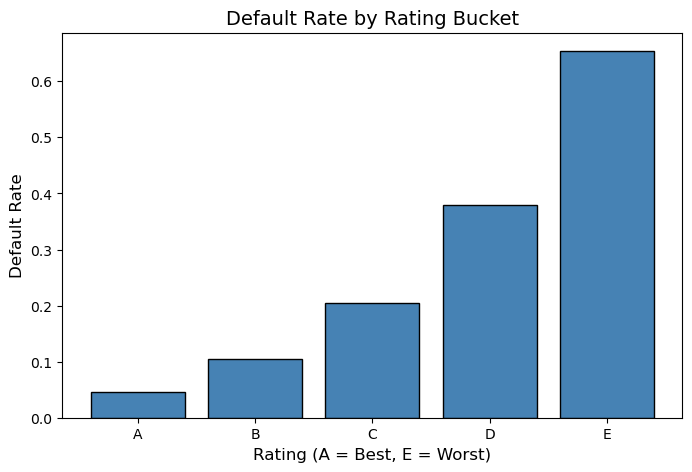

In [16]:
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary['default_rate'], color='steelblue', edgecolor='black')
plt.title("Default Rate by Rating Bucket", fontsize=14)
plt.xlabel("Rating (A = Best, E = Worst)", fontsize=12)
plt.ylabel("Default Rate", fontsize=12)
plt.show()

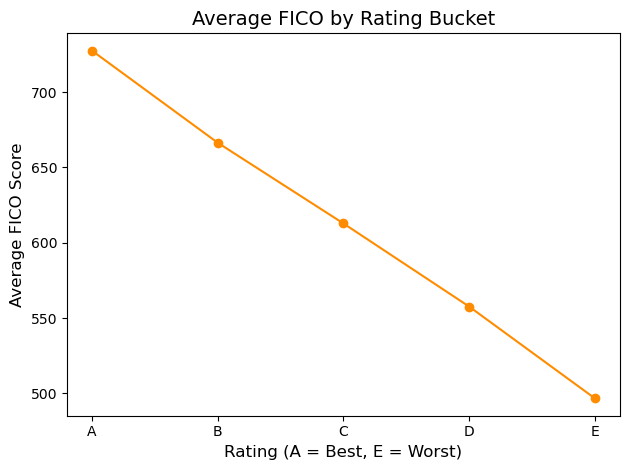

In [39]:
plt.plot(summary.index, summary['avg_fico'], marker='o', linestyle='-', color='darkorange')
plt.title("Average FICO by Rating Bucket", fontsize=14)
plt.xlabel("Rating (A = Best, E = Worst)", fontsize=12)
plt.ylabel("Average FICO Score", fontsize=12)

plt.tight_layout()
plt.show()